In [0]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    root = './'

Mounted at /content/drive


In [0]:
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [0]:
import importlib
import util
importlib.reload(util)
from util import *

## The Training Loop

In [0]:
loss = torch.nn.MSELoss()

In [0]:
def train_it(dataset, model, OPTIM, learning_rate = 1e-4, Npast=1, Nfuture=1):
    optimizer = OPTIM(model.parameters(), lr=learning_rate)
    Nepoch = 1000

    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Nbatch = Ntotal//10
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 10
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        y_pred = model(xx)+xx
        L = loss(y_pred,yy)
        h = y_pred
        #for i in range(Nfuture-1):
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss(yyt,yt_pred)
            losses[e//Nsave,0] = L.item()
            losses[e//Nsave,1] = test_err.item()
    return losses

# Test the learning rate:
Let's do a hyperparameter search on the learning rate on the simplest model:

In [0]:
Dt,Dx = 0.25/100 , 1.0/41
alpha = 0.1*Dt/(Dx**2)
print(alpha)
mystencil = PureStencil(Nx)
p = list(mystencil.parameters())[0]
p[0,0,0] =  1 * alpha
p[0,0,1] =  -2 * alpha
p[0,0,2] =  1 * alpha

0.42025


In [0]:
list(mystencil.parameters())

[Parameter containing:
 tensor([[[ 0.4202, -0.8405,  0.4202]]], grad_fn=<CopySlices>)]

In [0]:
dataset.shape

torch.Size([10, 100, 41])

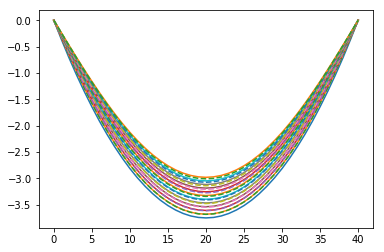

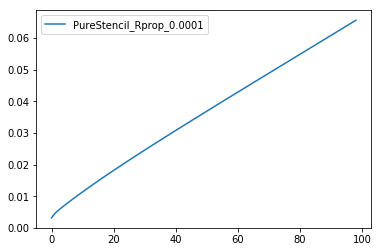

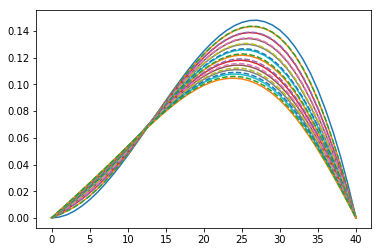

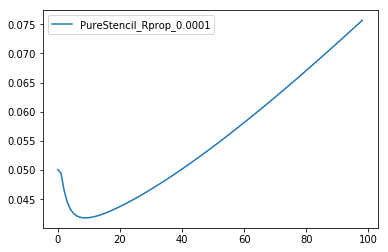

In [0]:
data = np.load(root+f"data/{dataname}.npz")
dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    err[N] = do_a_path(mystencil.to(device),dataset,i,-1)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()

In [0]:
stash_hyper_search = {}

In [0]:
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    name = "PureStencil"
    model_cls = models[name]
    optimizers = [torch.optim.Adam, torch.optim.Rprop] # torch.optim.SGD,
    for opt in optimizers:
        for lr in [1.0e-1,1.0e-2]:#,1.0e-3,1.0e-4]:
            print("Training ",name, "using ",opt.__name__," @ lr = ",lr)
            model = model_cls(Nx).to(device)
            results = train_it(dataset,model,OPTIM=opt,learning_rate=lr)
            stash_hyper_search[f"{name}_{opt.__name__}_{lr}"] = {'model':model,'loss':results}

Training  PureStencil using  Adam  @ lr =  0.1
999 2.1553469196078368e-05
1999 7.186766652012011e-06
2999 8.130510877890629e-07
3999 6.201896951552044e-08
4999 4.459224545172447e-09
5999 9.45168449106859e-06
6999 3.427002411626745e-06
7999 3.677656235101523e-10
8999 1.1966491797466006e-08
9999 2.1286086848704144e-06
Training  PureStencil using  Adam  @ lr =  0.01
999 2.2617030481342226e-05
1999 2.1717502022511326e-05
2999 1.573247936903499e-05
3999 9.203899026033469e-06
4999 3.5840621421812102e-06
5999 7.068989589242847e-07
6999 4.19312904398339e-08
7999 1.1607371952493395e-08
8999 7.373767152429878e-10
9999 5.858741825015557e-10
Training  PureStencil using  Rprop  @ lr =  0.1
999 3.2293351978296414e-05
1999 4.268569318810478e-05
2999 3.307002043584362e-05
3999 2.8688073143712245e-05
4999 3.834882954834029e-05
5999 3.8913181924726814e-05
6999 3.5979544918518513e-05
7999 3.5619006666820496e-05
8999 3.981054396717809e-05
9999 3.529031528159976e-05
Training  PureStencil using  Rprop  @ lr

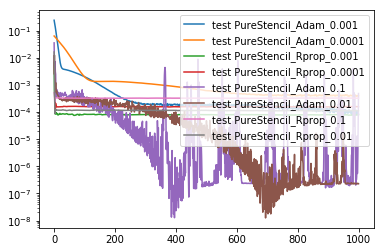

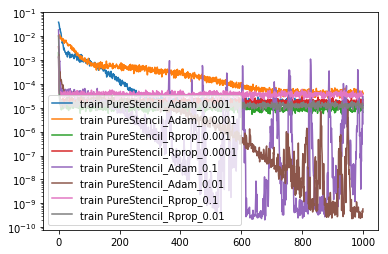

In [0]:
for N,S in stash_hyper_search.items():
    plt.semilogy(S['loss'][:,1],label=f"test {N}")
    plt.legend()
plt.show()
for N,S in stash_hyper_search.items():
    plt.semilogy(S['loss'][:,0],label=f"train {N}")
    plt.legend()
plt.show()

In [0]:
for k,v in stash_hyper_search.items():
    print(k,":",list(v['model'].parameters())[0].cpu().detach().numpy())

PureStencil_Adam_0.001 : [[[ 0.16958407 -0.34188315  0.16588183]]]
PureStencil_Adam_0.0001 : [[[-0.06283122  0.11868434 -0.07050063]]]
PureStencil_Rprop_0.001 : [[[ 0.18853071 -0.38499734  0.18977275]]]
PureStencil_Rprop_0.0001 : [[[ 0.10422343 -0.22094287  0.10734271]]]
PureStencil_Adam_0.1 : [[[ 0.39218616 -0.8031547   0.39224488]]]
PureStencil_Adam_0.01 : [[[ 0.39908972 -0.79820395  0.39913264]]]
PureStencil_Rprop_0.1 : [[[-0.01926213  0.02744331 -0.02142303]]]
PureStencil_Rprop_0.01 : [[[ 0.15567192 -0.30935293  0.14585517]]]


In [0]:
0.18/0.1, 0.38/0.22

(1.7999999999999998, 1.7272727272727273)

In [0]:
print([alpha,-2*alpha,alpha])

[0.42025, -0.8405, 0.42025]


PureStencil_Adam_0.001


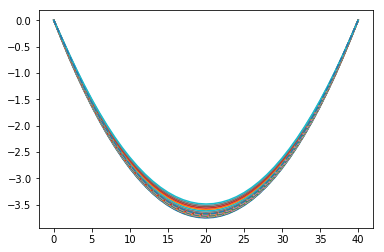

PureStencil_Adam_0.0001


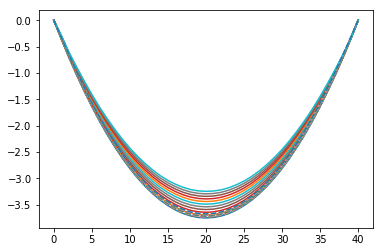

PureStencil_Rprop_0.001


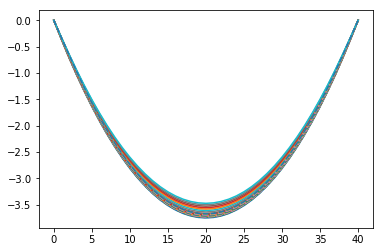

PureStencil_Rprop_0.0001


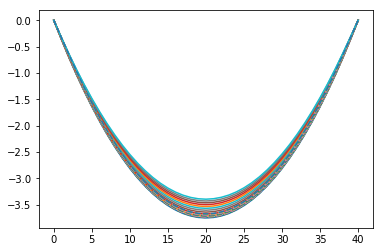

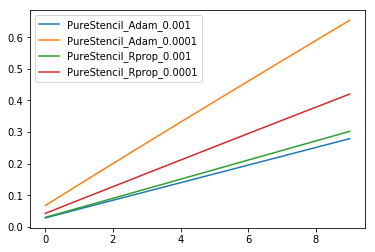

PureStencil_Adam_0.001


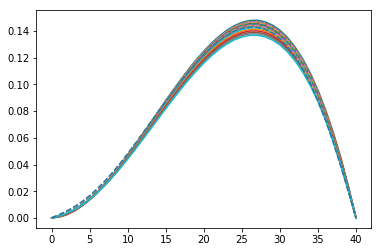

PureStencil_Adam_0.0001


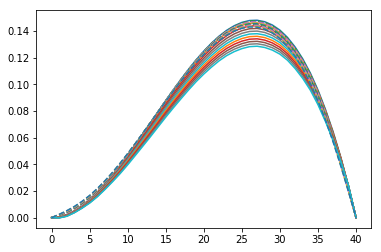

PureStencil_Rprop_0.001


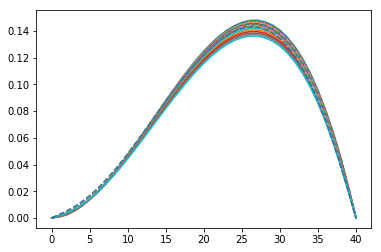

PureStencil_Rprop_0.0001


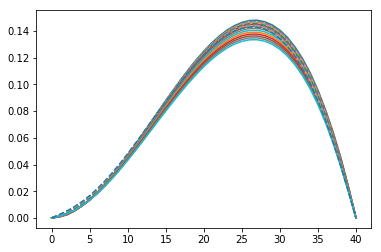

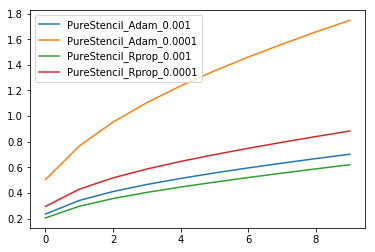

In [0]:
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    for N,S in stash_hyper_search.items():
        print(N)
        err[N] = do_a_path(S['model'],dataset,i,10)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()

# Test the precision

In [181]:
data['U'].dtype

dtype('float64')

# Test the model architecture:

Train all of the models on one of the datasets:

In [0]:
stash = {}
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    for name, cls in models.items():
        print("Training ",name)
        model = cls(Nx).to(device)
        results = train_it(dataset,model)
        stash[name] = {'model':model,
                       'loss':results}

Training  PureStencil
469 0.03963601216673851
939 0.00200735148973763
1409 0.0001733826065901667
1879 0.000265089183812961
2349 0.00024070274957921356
2819 0.0002627719659358263
3289 0.00027606659568846226
3759 0.00026130207697860897
4229 0.0005204282351769507
4699 0.00017044182459358126
Training  PureLinear
469 5.3663036680973164e-08
939 5.713600259582563e-08
1409 6.901895233113464e-08
1879 3.094091027833201e-07
2349 4.9930477530324424e-08
2819 6.964145882193407e-08
3289 1.2078187694442022e-07
3759 1.2886064837402955e-07
4229 3.117466462754237e-07
4699 2.553741751398775e-07
Training  DeepStencil
469 0.00020234445401001722
939 0.00016016370500437915
1409 0.00011156836262671277
1879 0.00016290300118271261
2349 8.411544695263728e-05
2819 5.814369797008112e-05
3289 4.84554075228516e-05
3759 2.7151914764544927e-05
4229 1.5781237379997037e-05
4699 1.0390561328676995e-05
Training  FCMLP
469 1.8734567674982827e-07
939 5.8418489601308465e-08
1409 5.437758332504927e-08
1879 4.412521903418565e-0

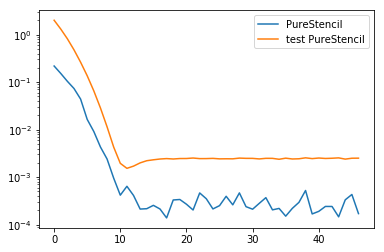

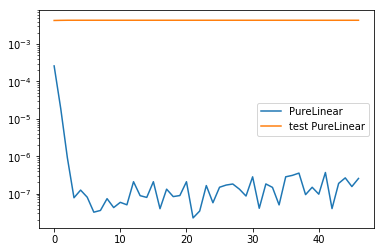

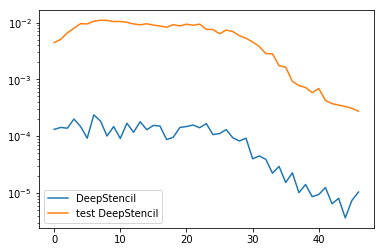

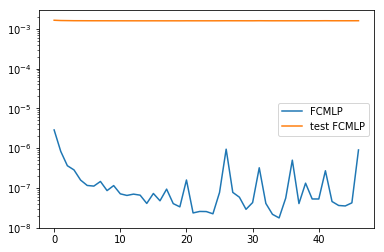

In [0]:
for N,S in stash.items():
    plt.semilogy(S['loss'][:,0],label=N)
    plt.semilogy(S['loss'][:,1],label=f"test {N}")
    plt.legend()
    plt.show()

PureStencil


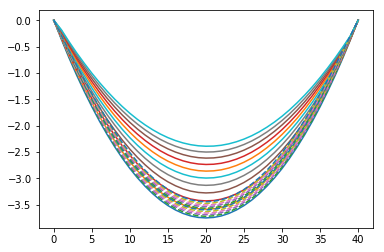

PureLinear


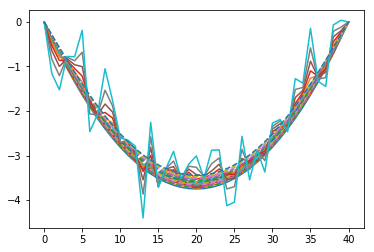

DeepStencil


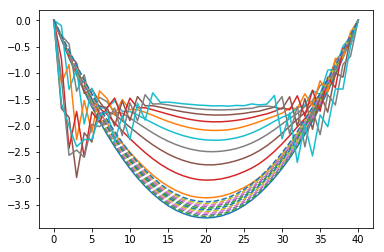

FCMLP


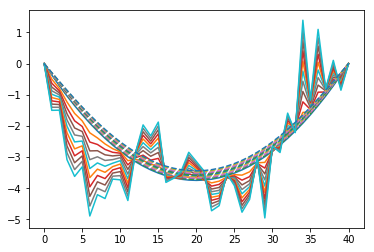

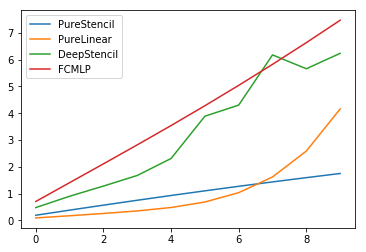

PureStencil


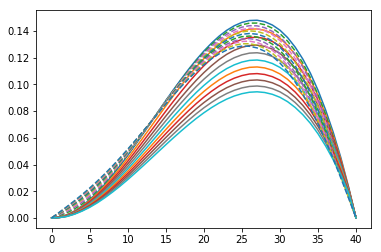

PureLinear


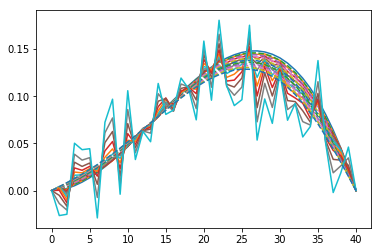

DeepStencil


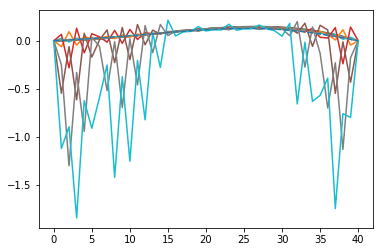

FCMLP


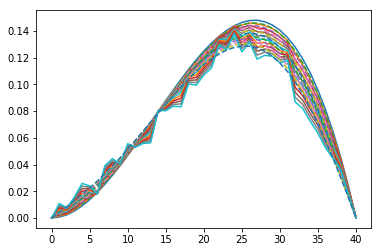

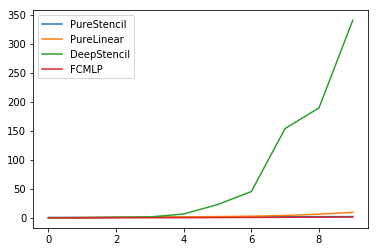

In [0]:
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    for N,S in stash.items():
        print(N)
        err[N] = do_a_path(S['model'],dataset,i,10)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()


In [0]:
list(stash["PureStencil"]['model'].parameters())

[Parameter containing:
 tensor([[[ 0.0035, -0.0291, -0.0185]]], device='cuda:0', requires_grad=True)]

In [0]:
outfile = open(root+'/db','wb')
torch.save(stash,outfile)
outfile.close()